In [5]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from pandas import merge, concat, read_csv, DataFrame, Series, isnull, date_range, read_excel, MultiIndex, cut
from IPython.core.display import HTML
from datetime import datetime, timedelta
from collections import defaultdict

# my things
import useful_functions_py3 as ufu
import mydf

get_ipython().run_line_magic(u'matplotlib', u'inline')

sns.set(style='white')
sns.set_style('ticks')

In [6]:
import subprocess, os
import util as ufu

import geopandas as gp

from importlib import reload

from matplotlib import markers
from matplotlib.cm import ScalarMappable
from matplotlib.colors import LogNorm, Normalize, hex2color
from matplotlib.patches import Polygon, Rectangle, Circle
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

import copy
from scipy.spatial.distance import pdist, squareform, hamming

from scipy.stats import pearsonr, spearmanr

from sklearn import metrics

from itertools import product, permutations

import json

import time
#import imageio

from IPython.display import Audio, display

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# identify and map top exporters

In [7]:
SEX = 'M'  # select sex

In [8]:
df_n = read_csv('./data/n.csv', index_col=0)
df_a = read_csv('./data/a.csv', index_col=0)

In [9]:
drisk = read_csv('./comp/{}_marginal.csv'.format(SEX), index_col=0)
drisk = drisk.assign(pop = df_n['POPULATION']/df_n['POPULATION'].sum())
drisk.head()

,local,visitor,travel,q,mobility,total,visitor/mobility,travel/mobility,visitor/total,travel/total,local/total,mobility/total,out visitor,out travel,out mobility,pop
Kabe,0.179865,0.021474,0.073261,0.263,0.094736,0.274600,0.226675,0.773325,0.078202,0.266793,0.655005,0.344995,0.166886,0.084901,0.251786,0.010139
Katima Muliro Rural,0.139817,0.065985,0.060786,0.263,0.126771,0.266588,0.520505,0.479495,0.247516,0.228015,0.524469,0.475531,0.118102,0.276639,0.394741,0.007639
Katima Muliro Urban,0.252556,0.048137,0.035267,0.390,0.083404,0.335960,0.577158,0.422842,0.143282,0.104973,0.751745,0.248255,0.415468,0.821344,1.236812,0.016309
Kongola,0.154427,0.045169,0.069426,0.263,0.114596,0.269023,0.394162,0.605838,0.167901,0.258069,0.574030,0.425970,0.086390,0.103047,0.189438,0.004236
Linyandi,0.173796,0.042757,0.056112,0.263,0.098869,0.272665,0.432462,0.567538,0.156811,0.205790,0.637399,0.362601,0.065205,0.099227,0.164431,0.004214


In [13]:
shp = gp.GeoDataFrame.from_file('./data/nam.shp').set_index('index', verify_integrity=True)
shp.head()

,geometry
index,
Berseba,"POLYGON ((16.98774 -27.75138, 16.94437 -27.718..."
Karas,"POLYGON ((19.99779 -27.37063, 19.99776 -27.401..."
Keetmanshoop Rural,"POLYGON ((19.99965 -25.60918, 19.99969 -25.616..."
Keetmanshoop Urban,"POLYGON ((18.10092 -26.44756, 18.10142 -26.439..."
Luderitz,"MULTIPOLYGON (((15.27069 -27.17542, 15.27069 -..."


In [16]:
temp = DataFrame({'risk': drisk['out mobility']})
bins = np.percentile(temp.values, [90, 80, 70, 60])
temp = temp.assign( bin = np.digitize(temp.values, bins) )
dgeo = merge(shp, temp, left_index=True, right_index=True, how='left')
dgeo = dgeo.assign( bin = dgeo['bin'].fillna(4).astype(int))

dgeo.head()

,geometry,risk,bin
index,,,
Berseba,"POLYGON ((16.98774 -27.75138, 16.94437 -27.718...",0.268601,4
Karas,"POLYGON ((19.99779 -27.37063, 19.99776 -27.401...",0.360275,4
Keetmanshoop Rural,"POLYGON ((19.99965 -25.60918, 19.99969 -25.616...",0.125411,4
Keetmanshoop Urban,"POLYGON ((18.10092 -26.44756, 18.10142 -26.439...",0.428704,3
Luderitz,"MULTIPOLYGON (((15.27069 -27.17542, 15.27069 -...",0.134097,4


In [17]:
def choromap(ax, dgeo, **kwarg):
    """
    ax -> matplotlib axes
    dgeo -> geodataframe
    column -> column giving the values for the cmap
    kwarg -> keywords for dgeo.plot
    """
    
    mesk = isnull(dgeo[column])
    
    # nan values
    temp = dgeo[mesk]
    if temp.shape[0]>0:
        kwargt = {}
        for a, b in kwarg.items():
            if a != 'cmap' and a != 'vmin' and a != 'vmax':
                kwargt[a] = b
        dgeo[mesk].plot(ax=ax, color='w', hatch="//", **kwargt)
        
    dgeo[~mesk].plot(ax=ax, column=column, **kwarg)

In [18]:
lcol = ['#e41a1c','yellow', '#f0b6ff', '#377eb8'] + ['0.9']

In [19]:
def insettore(ax, rect, loc, corner1=2, corner2=4, zoom=2):
    
    xd, yd = rect[0]
    xu = xd + rect[1]
    yu = yd + rect[2]
    
    ax_inset = zoomed_inset_axes(ax, zoom, loc)
    ax_inset.set_xlim(xd, xu)
    ax_inset.set_ylim(yd, yu)
    ax_inset.set_xticks([])
    ax_inset.set_yticks([])
    
    for i, color in enumerate(lcol):
        mesk = dgeo['bin'] == i
        tempu = dgeo[mesk]
        tempu.plot(ax=ax_inset, color=color, edgecolors='k', lw=0.4)
        
    mark_inset(ax, ax_inset, loc1=corner1, loc2=corner2, fc="none", ec="0.5")

In [20]:
lrect = [((14, -23.25), 1., 1.), ((19.5, -18.), 0.5, 0.5), ((23.75, -18), 1., 1.) ]

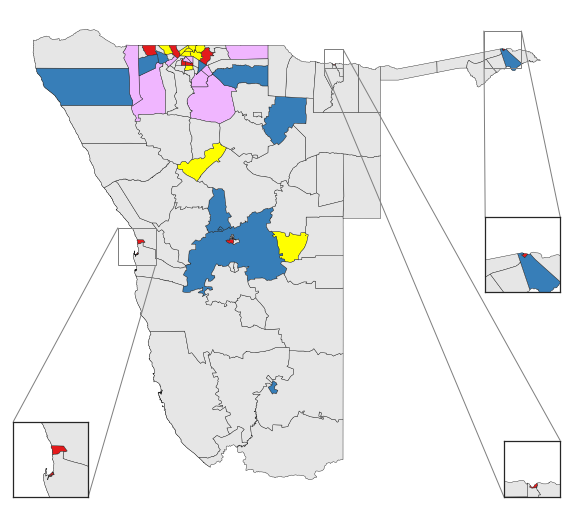

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set_axis_off()

for i, color in enumerate(lcol):
    mesk = dgeo['bin'] == i
    tempu = dgeo[mesk]
    tempu.plot(ax=ax, color=color, edgecolors='k', lw=0.4)
    
ax.set_aspect('equal')


insettore(ax, lrect[0], 'lower left')
insettore(ax, lrect[1], 'lower right', corner1=3, corner2=1, zoom=3)
insettore(ax, lrect[2], 'center right', corner1=1, corner2=2)



In [22]:
ufu.display_colors(lcol[:-1])